In [4]:
# Biblioteca para trabalhar com grafos
import networkx as nx

# Biblioteca para plotar os grafos
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

import numpy as np
import random as rd
import tsplib95

In [5]:
def NearestNeighbor(mat):
    assert isinstance(mat, np.matrix), "use np.matrix"
    n = len(mat)
    used = np.zeros(n, dtype=bool)
    used[0] = True
    cost = 0
    last = 0
    path = [0]
    for i in range(1, n):
        minarg = -1
        min = np.inf
        for j in range(1, n):
            if (not used[j] and mat[last, j] < min):
                min = mat[last, j]
                minarg = j
        if minarg >= 0:
            cost += min
            last = minarg
            path.append(last)
            used[last] = True

    cost += mat[last, 0]
    return cost, path

In [6]:
def get_distance_matrix(problem):
    n = problem.dimension
    plus = 0
    if next(problem.get_nodes()) == 1:
        plus = 1

    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + plus, n):
            distance_matrix[i, j] = problem.get_weight(i + plus, j + plus)
    
    return distance_matrix

In [7]:
def randomGraph(n, W=1000, H=1000):
    coordinates = []
    for i in range(n):
        coordinates.append((rd.randint(0, W), rd.randint(0, H)))
    dist_matrix = squareform(pdist(coordinates))
    G = nx.complete_graph(n)
    for i in range(n):
        G.nodes[i]["coord"] = coordinates[i]
        G.nodes[i]["label"] = i
        for j in range(i):
            G.edges[i,j]['weight'] = G.edges[j,i]['weight'] = dist_matrix[i][j]
    return G

In [8]:
def testGraph(problem):
    coordinates = list(problem.node_coords.values())
    dist_matrix = squareform(pdist(coordinates))
    #dist_matrix = get_distance_matrix(problem)
    G = nx.complete_graph(problem.dimension)
    
    for i in range(problem.dimension):
        G.nodes[i]["pos"] = coordinates[i]
        G.nodes[i]["label"] = i
    return G, dist_matrix

In [9]:
def oneTree(oneT, Gm1, mat, pi):
    assert isinstance(mat, np.matrix), "use np.matrix"
    n = Gm1.number_of_nodes()
    for i in range(n):
        for j in range(i):
            Gm1.edges[i, j]['weight'] = Gm1.edges[j, i]['weight'] = mat[i, j] + pi[i] + pi[j]

    # gerando a árvore com o restando dos nós.
    spaningTree = nx.minimum_spanning_tree(Gm1, algorithm="kruskal", weight='weight')
    # nx.draw_networkx(spaningTree, spaningTree.nodes.data('pos'), with_labels=True, node_size=200, font_size=8)
    # localizar as menores arestas que conectam o nó removido na matriz de distâncias
    vet = np.zeros(n)
    for i in range(n):
        vet[i] = mat[n,i] + pi[i] + pi[n]
    a, b = np.argpartition(vet, 2)[:2]

    # inserindo o nó removido
    oneT.clear_edges()
    oneT.add_edges_from(spaningTree.edges)
    oneT.add_edge(n, a)
    oneT.add_edge(n, b)
    return

In [10]:
def w_funcPi(graph, mat, pi):
    assert isinstance(mat, np.matrix), "use np.matrix"
    cost = 0
    for i, j in graph.edges:
        cost += mat[i,j] + pi[i] + pi[j]
    return cost

In [11]:
def w_func(graph, mat):
    assert isinstance(mat, np.matrix), "use np.matrix"
    cost = 0
    for i, j in graph.edges:
        cost += mat[i][j]
    return cost

In [12]:
def degree(graph):
    n = graph.number_of_nodes()
    d = np.zeros(n)
    deg = graph.degree()
    for i in range(n):
        d[i] = deg[i]
    return d

In [13]:
def all_equals(vet, x):
    for i in vet:
        if x != i:
            return False
    return True

In [14]:
def subGrad(ub, G, mat, LAMBDA=1.61, eps=1e-4):
    n = G.number_of_nodes()
    # one tree
    oneT = nx.Graph.copy(G)
    # G menos o último vertice
    Gm1 = nx.Graph.copy(G)
    Gm1.remove_node(n - 1)
    # vetor de pesos
    pi = np.zeros(n)
    # melhor vetor de pesos encontrado
    bestPi = np.zeros(n)

    L = 2
    oneTree(oneT, Gm1, mat, pi)
    maxW = w = w_funcPi(oneT, mat, pi)
    # número de iterações
    ite = 1
    while (L > eps):
        d = degree(oneT)
        if all_equals(d, 2):
            print("Ciclo Hamiltoniano encontrado.")
            break
        # subgradiente
        g = d - 2
        # passo
        # if t == -1:
        t = ((ub + 2 * sum(bestPi)) - w) / (np.linalg.norm(g) ** 2)
        while L > eps:
            ite += 1
            pi = pi + L * t * g
            oneTree(oneT, Gm1, mat, pi)
            w = w_funcPi(oneT, mat, pi)
            if w > maxW + eps:
                np.copyto(bestPi, pi)
                maxW = w
                break
            else:
                L /= LAMBDA
                np.copyto(pi, bestPi)
                w = maxW
        print("%-6d UBgap:%7.2lf%% \t|g|:%.2lf  \tL:%.5lf" % (ite, 100 * w / ub, np.linalg.norm(g), L))

    oneTree(oneT, Gm1, mat, bestPi)
    return bestPi, oneT, w

In [17]:
def compareSolutions(oficialSolution, mat, oneT, w):
    lista = list(oneT.edges)
    arr = list(np.array(oficialSolution.tours[0]) - 1)

    oficialSolutionEdges = [(arr[-1], arr[0])]
    for i in range(len(arr) - 1):
        j = i + 1
        oficialSolutionEdges.append((arr[i], arr[j]))

    print("Optional solution", lista)
    print('______________________________________________________________________________')
    oficialSolutionEdges = [(i,j) if i<j else (j,i) for i,j in oficialSolutionEdges];#list comprehension
    print("Optimal solution sort", oficialSolutionEdges)
    print('______________________________________________________________________________')
    intersectionEdges = set(lista) & set(oficialSolutionEdges);
    print("edges intersection", intersectionEdges);
    print('problem Length:' , len(lista))
    print('intersection Edges Length:' , len(intersectionEdges))
    print('percent Edges In Optimal:', ((len(intersectionEdges)*100)/len(oficialSolutionEdges)))
    w_oficial = 0
    for i, j in oficialSolutionEdges:
        w_oficial += mat[i,j]
    print("Oficial Solution:", w_oficial)
    print("OneTree Solution:", w)
    print('Gap of Function:', w_oficial - w)

22     UBgap:  48.10% 	|g|:2.83  	L:0.29729
23     UBgap:  55.47% 	|g|:5.83  	L:0.29729
24     UBgap:  56.79% 	|g|:4.00  	L:0.29729
26     UBgap:  56.93% 	|g|:5.10  	L:0.27026
27     UBgap:  58.75% 	|g|:3.74  	L:0.27026
29     UBgap:  58.88% 	|g|:2.83  	L:0.24569
30     UBgap:  58.95% 	|g|:3.16  	L:0.24569
31     UBgap:  62.38% 	|g|:4.00  	L:0.24569
32     UBgap:  63.63% 	|g|:4.24  	L:0.24569
35     UBgap:  63.72% 	|g|:3.74  	L:0.20305
36     UBgap:  65.18% 	|g|:4.69  	L:0.20305
40     UBgap:  65.30% 	|g|:2.45  	L:0.15256
42     UBgap:  65.41% 	|g|:3.46  	L:0.13869
43     UBgap:  66.35% 	|g|:4.00  	L:0.13869
47     UBgap:  66.37% 	|g|:2.45  	L:0.10420
48     UBgap:  67.57% 	|g|:4.24  	L:0.10420
58     UBgap:  67.64% 	|g|:2.45  	L:0.04419
60     UBgap:  67.68% 	|g|:2.45  	L:0.04017
61     UBgap:  68.08% 	|g|:3.16  	L:0.04017
64     UBgap:  68.11% 	|g|:2.83  	L:0.03320
65     UBgap:  68.12% 	|g|:2.00  	L:0.03320
72     UBgap:  68.13% 	|g|:2.45  	L:0.01874
73     UBgap:  68.25% 	|g|:2.83 

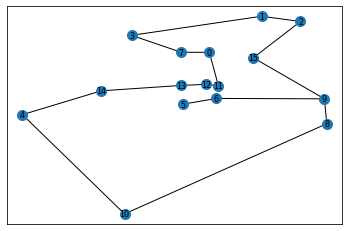

In [18]:
rd.seed(7)

G = tsplib95.load('../../instances/tsp_data/ulysses16.tsp').get_graph(True)
optimalSolution = tsplib95.load('../../instances/tsp_opt/ulysses16.opt.tour')


# G = randomGraph(50)


mat = nx.to_numpy_matrix(G)
ub, path = NearestNeighbor(mat)

pi, oneT, w = subGrad(ub, G, mat, LAMBDA=1.1)
compareSolutions(optimalSolution, mat, oneT, w)

nx.draw_networkx(oneT, oneT.nodes.data('coord'), with_labels=True, node_size=100, font_size=8)
plt.show()